Reproduire [Active learning](https://github.com/lunayht/DBALwithImgData/tree/main?tab=readme-ov-file)
avec des [images de dechets](https://archive.ics.uci.edu/dataset/908/realwaste)

expérience realisée en local : RTX3060

# imports 

In [1]:
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
import os 
from scipy import stats
import scipy


In [3]:
from scipy.ndimage import gaussian_filter1d

In [4]:
import seaborn as sns

In [5]:
import time

In [6]:
from skorch import NeuralNetClassifier

In [7]:
from modAL.models import ActiveLearner

In [8]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [9]:
# 1. Définir le chemin vers le dossier racine des données
data_dir = '../RealWaste'

# Load data 

In [10]:
def tensor_to_np(tensor_data: torch.Tensor) -> np.ndarray:
    """
    Since Skorch doesn not support dtype of torch.Tensor, we will modify
    the dtype to numpy.ndarray
    Attribute:
        tensor_data: Data of class type=torch.Tensor
    """
    np_data = tensor_data.detach().numpy()
    return np_data

In [11]:
# 2. Définir les transformations pour les images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),               
])

In [12]:

if os.path.isdir(data_dir):
    realwaste_dataset = ImageFolder(root=data_dir, transform=data_transforms)

    print(f"Nombre total d'images trouvées : {len(realwaste_dataset)}")
    print(f"Classes trouvées : {realwaste_dataset.classes}")
    print(f"Mapping classe -> index : {realwaste_dataset.class_to_idx}")

    batch_size = 32 
    realwaste_dataloader = DataLoader(realwaste_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 

    try:
        images, labels = next(iter(realwaste_dataloader))        
    except StopIteration:
        print("\nLe DataLoader est vide (aucune image chargée).")
    except Exception as e:
        print(f"\nErreur lors de la récupération d'un lot : {e}")

else:
    print(f"Le dossier spécifié n'existe pas : {data_dir}")


Nombre total d'images trouvées : 4752
Classes trouvées : ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Mapping classe -> index : {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


In [13]:
# Create a mapping from index to class name
idx_to_class = {v: k for k, v in realwaste_dataset.class_to_idx.items()}

Number of images in each category:
Cardboard: 461 images
Food Organics: 411 images
Glass: 420 images
Metal: 790 images
Miscellaneous Trash: 495 images
Paper: 500 images
Plastic: 921 images
Textile Trash: 318 images
Vegetation: 436 images


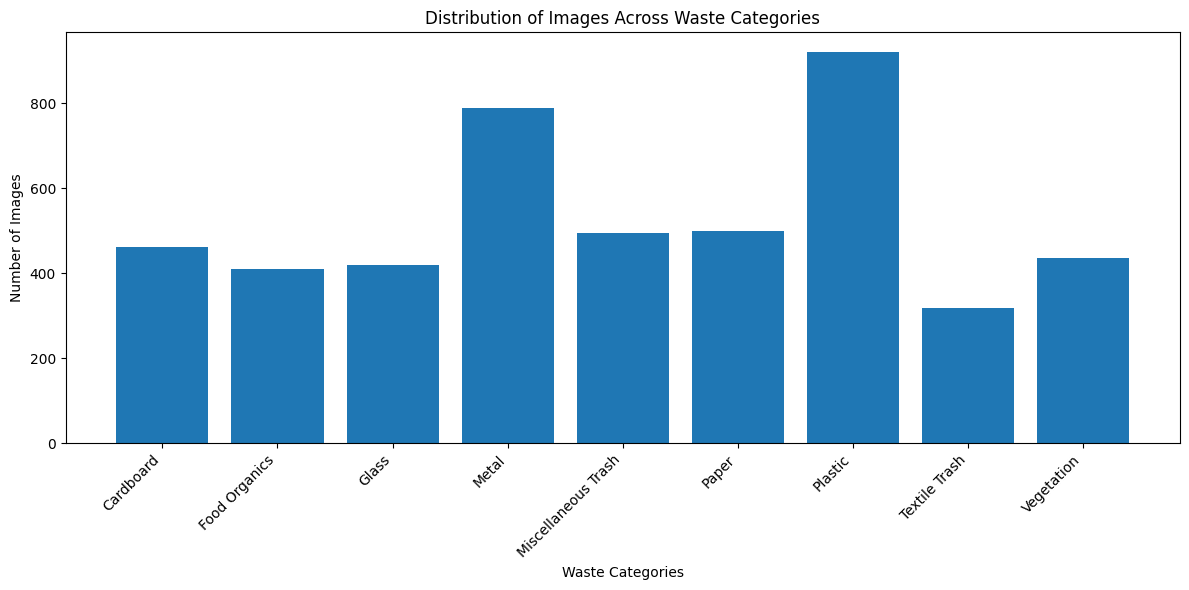

In [14]:
# Count the number of images per class
class_counts = {}
for img_path, class_idx in realwaste_dataset.samples:
    class_name = idx_to_class[class_idx]
    if class_name in class_counts:
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 1

# Sort the dictionary by class name for better readability
sorted_class_counts = {k: class_counts[k] for k in sorted(class_counts.keys())}

# Display the results
print("Number of images in each category:")
for class_name, count in sorted_class_counts.items():
    print(f"{class_name}: {count} images")

# Create a bar chart to visualize the distribution
plt.figure(figsize=(12, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.xlabel('Waste Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Waste Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

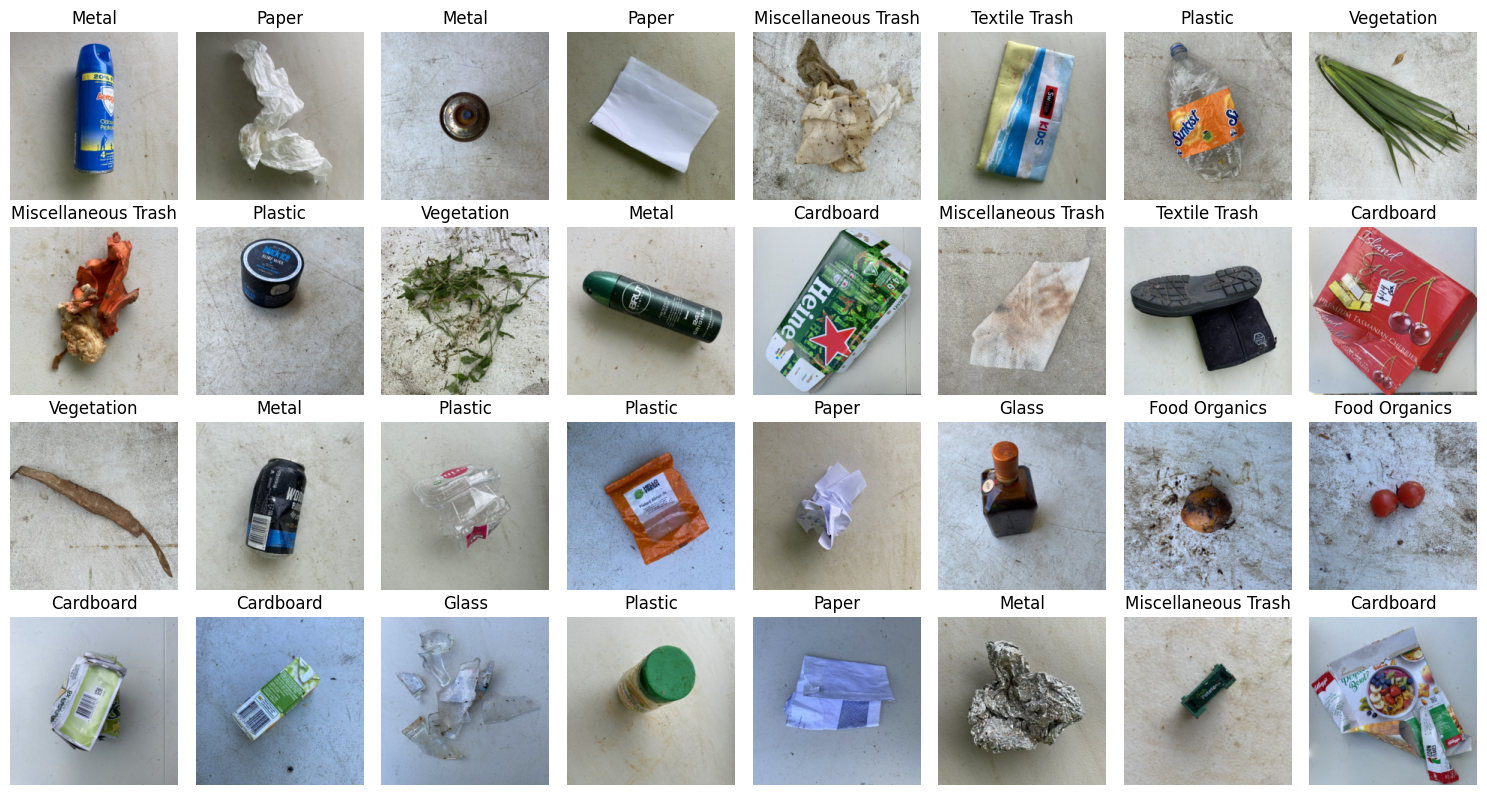

In [15]:
# Create a figure to display images
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.flatten()

# Display up to 32 images
for i in range(min(32, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    class_name = idx_to_class[labels[i].item()]
    
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

# Hide any unused subplots
for i in range(len(images), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Dans l'article, il est question de modèle de classification binaire, dans notre cas nous allons essayer d'implementer cette architechture avec un modèle de classification a classe multiples 

In [16]:
#split the dataset into training and testing sets
all_data = []
all_labels = []

In [17]:
for i in range(len(realwaste_dataset)):
    image, label = realwaste_dataset[i]
    all_data.append(image)
    all_labels.append(label)

In [18]:
# Conversion en tenseurs
all_data = torch.stack(all_data)
all_labels = torch.tensor(all_labels)

In [19]:
# Conversion en numpy arrays
X_data = tensor_to_np(all_data)
y_labels = tensor_to_np(all_labels)

In [20]:
# utiliser un sous ensemble des données pour le prototypage
sample_size = 1000 
indices = np.random.choice(range(len(all_data)), size=sample_size, replace=False)

In [21]:
X_data_sample = X_data[indices]
y_labels_sample = y_labels[indices]

In [22]:
# repartiion des classes dans le sous enasemble
class_counts_sample = {}
for label in y_labels_sample:
    class_name = idx_to_class[label]
    if class_name in class_counts_sample:
        class_counts_sample[class_name] += 1
    else:
        class_counts_sample[class_name] = 1

In [23]:
# faire un split stratifié en fonction des classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42, train_size=sample_size)

In [24]:
for i, (train_index, test_index) in enumerate(sss.split(X_data, y_labels)):
    X_data_sample_stratified = X_data[train_index]
    y_labels_sample_stratified= y_labels[train_index]

In [25]:
class_counts_sample_strat = {}
for label in y_labels_sample_stratified:
    class_name = idx_to_class[label]
    if class_name in class_counts_sample_strat:
        class_counts_sample_strat[class_name] += 1
    else:
        class_counts_sample_strat[class_name] = 1

In [26]:

class_counts_sample_sorted = {k: class_counts_sample[k] for k in sorted(class_counts_sample.keys())}
class_counts_sample_strat_sorted = {k: class_counts_sample_strat[k] for k in sorted(class_counts_sample_strat.keys())}

In [27]:
print(class_counts_sample_sorted)
print(class_counts_sample_strat_sorted)

{'Cardboard': 95, 'Food Organics': 101, 'Glass': 91, 'Metal': 165, 'Miscellaneous Trash': 90, 'Paper': 112, 'Plastic': 192, 'Textile Trash': 55, 'Vegetation': 99}
{'Cardboard': 97, 'Food Organics': 87, 'Glass': 88, 'Metal': 166, 'Miscellaneous Trash': 104, 'Paper': 105, 'Plastic': 194, 'Textile Trash': 67, 'Vegetation': 92}


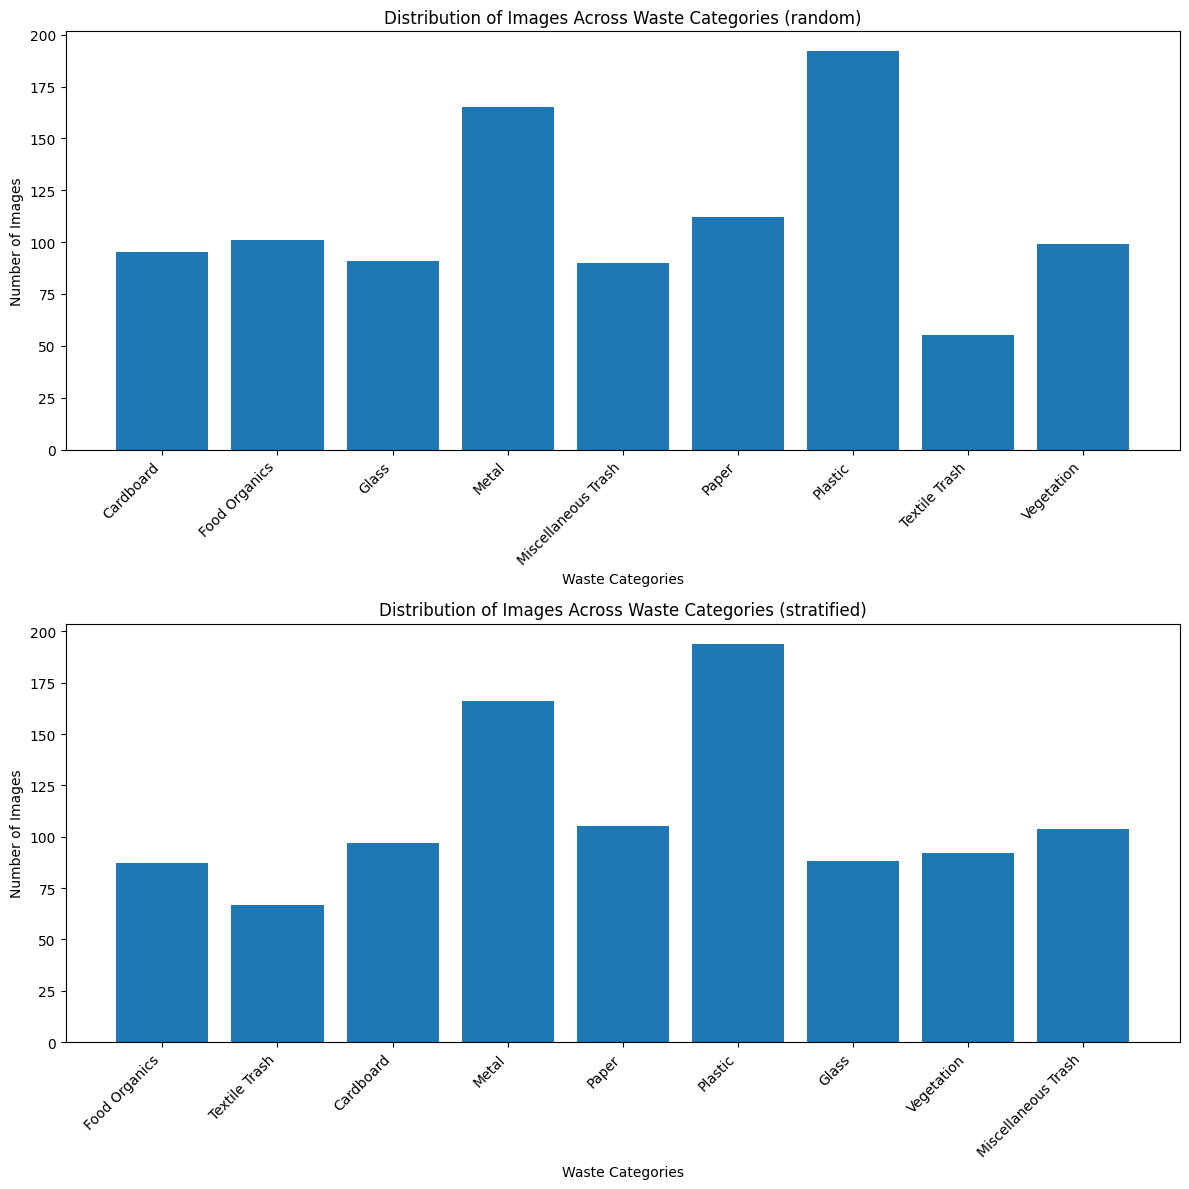

In [28]:
# plot deux bar graphes, un au dessus de l'autre pour comparer 
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)  
plt.bar(class_counts_sample_sorted.keys(), class_counts_sample_sorted.values())
plt.xlabel('Waste Categories')  
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Waste Categories (random)')
plt.xticks(rotation=45, ha='right')
plt.subplot(2, 1, 2)
plt.bar(class_counts_sample_strat.keys(), class_counts_sample_strat.values())
plt.xlabel('Waste Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Waste Categories (stratified)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

meme si la repartition des classes dans le sample cree de maniere aleatoire respocte relativement la répartition des classes, je vais continuer avec le sous ensemble stratifié pour mieux reproduire l'expérience 

In [29]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_data_sample_stratified, 
    y_labels_sample_stratified, 
    test_size=0.2,     
    random_state=50,    
    stratify=y_labels_sample   
)

In [30]:
X_temp.shape, y_temp.shape

((800, 3, 224, 224), (800,))

In [31]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,     
    random_state=42,
    stratify=y_temp
)

In [32]:
initial_idx = np.random.choice(range(len(X_train)), size=100, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

# Acquisition functions 

In [33]:
def predictions_from_pool(
    model, 
    X_pool: np.ndarray, 
    T: int = 100, 
    training: bool = True
):
    """
    Run random_subset prediction on model and return the output
    Attributes:
        X_pool: Pool set to select uncertainty,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    subset_size = min(500, len(X_pool))
    random_subset = np.random.choice(range(len(X_pool)), size=subset_size, replace=False)
    with torch.no_grad():
        outputs = np.stack(
            [
                torch.softmax(
                    model.estimator.forward(X_pool[random_subset], training=training),
                    dim=-1,
                )
                .cpu()
                .numpy()
                for _ in range(T)
            ]
        )
    return outputs, random_subset

In [34]:
def shannon_entropy_function(
    model, 
    X_pool: np.ndarray, 
    T: int = 100, 
    E_H: bool = False, 
    training: bool = True
):
    """
    H[y|x,D_train] := - sum_{c} p(y=c|x,D_train)log p(y=c|x,D_train)
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        T: Number of MC dropout iterations aka training iterations,
        E_H: If True, compute H and EH for BALD (default: False),
        training: If False, run test without MC dropout. (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training=training)
    pc = outputs.mean(axis=0)
    H = (-pc * np.log(pc + 1e-10)).sum(axis=-1) # To avoid division with zero, add 1e-10
    if E_H:
        E = -np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)
        return H, E, random_subset
    return H, random_subset    

def max_entropy(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """
    Choose pool points that maximise the predictive entropy.
    Using Shannon entropy function.
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise max_entropy a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    acquisition, random_subset = shannon_entropy_function(
        model, X_pool, T, training=training
    )
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]

In [35]:
def mean_std_acquisition(
    model, 
    X_pool: np.ndarray, 
    n_query: int = 10, 
    T: int = 100, 
    training: bool = True
):
    """
    Choisit les points du pool qui maximisent l'écart-type moyen des prédictions (Mean STD).
    σ_c = sqrt(E_q(ω)[p(y=c|x,ω)^2] - (E_q(ω)[p(y=c|x,ω)])^2)
    σ(x) = (1/C) * Σ_c (σ_c)

    Attributs:
        model: Modèle entraîné prêt pour la mesure d'incertitude.
        X_pool: Ensemble de données (pool) à partir duquel sélectionner.
        n_query: Nombre de points à interroger.
        T: Nombre d'itérations de Monte Carlo dropout.
        training: Si True, active le mode entraînement (par exemple, pour le dropout). (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training=training)

    # E_q(ω)[p(y=c|x,ω)]
    # Calcule la moyenne des probabilités sur les T passes pour chaque classe et chaque échantillon
    # expected_p_c a la forme (N_subset, C)
    expected_p_c = np.mean(outputs, axis=0)

    # E_q(ω)[p(y=c|x,ω)^2]
    # Calcule la moyenne des probabilités au carré sur les T passes
    # expected_p_c_squared a la forme (N_subset, C)
    expected_p_c_squared = np.mean(outputs**2, axis=0)

    # σ_c = E_q(ω)[p(y=c|x,ω)^2] - (E_q(ω)[p(y=c|x,ω)])^2
    # Calcule la variance pour chaque classe et chaque échantillon
    # sigma_c a la forme (N_subset, C)
    sigma_c = expected_p_c_squared - (expected_p_c**2)

    # σ(x) = (1/C) * Σ_c (σ_c)
    # Calcule la moyenne des variances sur toutes les classes pour chaque échantillon
    # acquisition_scores a la forme (N_subset,)
    acquisition_scores = np.mean(sigma_c, axis=-1) 

    # Sélectionner les n_query points avec les scores d'acquisition les plus élevés
    # argsort trie par ordre croissant, donc on utilise -acquisition_scores pour un tri décroissant
    idx = (-acquisition_scores).argsort()[:n_query]
    
    query_idx = random_subset[idx]
    
    return query_idx, X_pool[query_idx]

In [36]:
def bald(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """
    Choose pool points that are expected to maximise the information
    gained about the model parameters, i.e. maximise the mutal information
    between predictions and model posterior. Given
    I[y,w|x,D_train] = H[y|x,D_train] - E_{p(w|D_train)}[H[y|x,w]]
    with w the model parameters (H[y|x,w] is the entropy of y given w).
    Points that maximise this acquisition function are points on which the
    model is uncertain on average but there exist model parameters that produce
    disagreeing predictions with high certainty. This is equivalent to points
    with high variance in th einput to the softmax layer
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise bald a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    H, E_H, random_subset = shannon_entropy_function(
        model, X_pool, T, E_H=True, training=training
    )
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]

In [37]:
def var_ratios(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """
    Like Max Entropy but Variational Ratios measures lack of confidence.
    Given: variational_ratio[x] := 1 - max_{y} p(y|x,D_{train})
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise var_ratios a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training)
    preds = np.argmax(outputs, axis=2)
    _, count = stats.mode(preds, axis=0)
    acquisition = (1 - count / preds.shape[1]).reshape((-1,))
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]

# CNN architecture 

In [38]:
# dans l'article pour l'entrainement du modèle pour la classification d'images de lesions, l'architecture VGG16 a été utilisée donc 
# on va l'utiliser aussi pour la classification d'images de déchets
n_classes = len(realwaste_dataset.classes)

class VGG16(nn.Module):
    def __init__(self, n_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # layer 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # layer 2
            nn.Conv2d(64, 64, kernel_size=3,stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1,padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # layer 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # layer 6
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # layer 7
            nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # layer 9
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # layer 10
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 11
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # layer 12
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # layer 13
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Assuming input size is (224x224)
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x, training: bool = True):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        if training:
                # Active le dropout pendant l'entraînement
                self.classifier.train()
        else:
                # Désactive le dropout pendant l'évaluation
                self.classifier.eval()
                
        x = self.classifier(x)
        return x
        

In [39]:
# VGG16 model pre entrainé, modifier les dernieres couches pour la classification
vgg16_pretrained = models.vgg16(pretrained=True)
# Freeze the convolutional layers
for param in vgg16_pretrained.parameters():
    param.requires_grad = False

c:\Users\atcho\active_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\atcho\active_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Remplacer la dernière couche de classification par une nouvelle couche
num_features = vgg16_pretrained.classifier[6].in_features
vgg16_pretrained.classifier[6] = nn.Linear(num_features, n_classes)

for param in vgg16_pretrained.classifier[6].parameters():
    param.requires_grad = True

In [41]:
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=9, bias=True)
)

# Active Learning procedure

In [42]:
def active_learning(
    query_strategy,
    model, 
    x_validation: np.ndarray,
    y_validation: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    X_pool: np.ndarray, 
    y_pool: np.ndarray,
    X_initial: np.ndarray,
    y_initial: np.ndarray,
    n_query: int = 10, 
    n_iterations: int = 100, 
    training: bool = True
):
    """
    Choisit les points du pool qui maximisent l'entropie prédictive.
    Attributs:
        query_strategy: Stratégie d'interrogation à utiliser (par exemple, max_entropy).
        model: Modèle entraîné prêt pour la mesure d'incertitude.
        X_test, y_test: Test dataset,
        X_init, y_init: Données initiales d'entrainement,
        X_pool, y_pool: Ensemble de données (pool) à partir duquel sélectionner.
        n_query: Nombre de points à interroger.
        n_iterations: Nombre d'itérations de Monte Carlo dropout.
        training: Si True, active le mode entraînement (par exemple, pour le dropout). (default=True)
    """
    learner = ActiveLearner(
        estimator=model,
        query_strategy=query_strategy,
        X_training=X_initial, 
        y_training=y_initial,  
    )
    accuracy_scores = [learner.score(X_test, y_test)]
    for i in range(n_iterations):
        query_idx, query_inst = learner.query(
            X_pool, n_query=n_query,
            T=n_iterations, training=training
        )
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        # Remove the queried instance from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy_val = learner.score(x_validation, y_validation)
        if (i + 1) % 5 == 0:
            print(f"Val Accuracy after query {i+1}: {model_accuracy_val:0.4f}")
        accuracy_scores.append(model_accuracy_val)

    model_accuracy_test = learner.score(X_test, y_test)
    print(f"********** Test Accuracy per experiment: {model_accuracy_test} **********")
    return accuracy_scores, model_accuracy_test

# HyperParameters

In [43]:
torch.cuda.is_available()

True

In [44]:
ACQ_FUNCS=[max_entropy, bald, mean_std_acquisition, var_ratios]
BATCH_SIZE=32
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define the model
DROPOUT_ITER = 15
EPOCHS = 20
EXPERIMENTS = 2
N_QUERY = 10
LR = 1e-3
RESULT_DIR = "result_npy"
SEED = 350
p = 0.5
l2 = 1e-4
N = len(X_initial)
Weight_Decay = (1-p)*l2/N


In [45]:
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

print(f"Using device: {DEVICE}")

Using device: cuda:0


# Functions

In [ ]:
def load_CNN_model():
    """
    Load new model each time for different acqusition function
    each experiments"""
    ## VGG16 model pas pre entrainé
    # model = VGG16(n_classes=n_classes).to(DEVICE) 
    ## VGG16 model pre entrainé
    model = vgg16_pretrained.to(DEVICE)
    
    cnn_classifier = NeuralNetClassifier(
        module=model,
        lr=LR,
        batch_size=BATCH_SIZE,
        max_epochs=EPOCHS,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        train_split=None,
        verbose=0,
        device=DEVICE,
        optimizer__weight_decay=Weight_Decay,
    )
    return cnn_classifier

In [47]:
def save_as_npy(data: np.ndarray, name: str):
    """
    Save result as npy file
    
    Attributes:
        data: np array to be saved as npy file,
        folder: result folder name,
        name: npy filename
    """
    file_name = os.path.join(RESULT_DIR, name+".npy")
    np.save(file_name, data)
    print(f"Saved: {file_name}")

In [48]:
def plot_results(data: dict):
    """
    Plot results histogram using matplotlib with enhanced visualization.
    Attributes:
        data: Dictionary containing acquisition function names as keys and their respective scores as values.
    """
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 7))

    for key in data.keys():
        # Set the first value to 0 before applying Gaussian smoothing
        
        smoothed_data = gaussian_filter1d(data[key], sigma=0.9)
        raw_data = np.insert(smoothed_data, 0, 0.0)
        plt.plot(raw_data, label=key, linewidth=2)

    # Add labels, title, and legend
    plt.ylim([0.0, 1.00])
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.title('Active Learning Performance by Acquisition Function', fontsize=14)
    plt.legend(title="Acquisition Functions", fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [49]:
def print_elapsed_time(start_time: float, exp: int, acq_func: str):
    """
    Print elapsed time for each experiment of acquiring
    Attributes:
        start_time: Starting time (in time.time()),
        exp: Experiment iteration
        acq_func: Name of acquisition function
    """
    elp = time.time() - start_time
    print(
        f"********** Experiment {exp} ({acq_func}): last {int(elp//3600)} H :\
            {int(elp%3600//60)} min :{int(elp%60)} sec **********")

# Start Active Learning with Acquisition Functions

In [50]:
results = dict()

for i, acq_func in enumerate(ACQ_FUNCS):
    avg_hist = []
    test_scores = []
    acq_func_name = str(acq_func).split(" ")[1]
    print(f"\n---------- Start {acq_func_name} training! ----------")
    for e in range(EXPERIMENTS):
        start_time = time.time()
        estimator = load_CNN_model()
        print(
            f"********** Experiment Iterations: {e+1}/{EXPERIMENTS} **********"
        )
        training_hist, test_score = active_learning(
            query_strategy=acq_func,
            x_validation=X_validation,
            y_validation=y_validation,
            X_test=X_test,
            y_test=y_test,
            X_pool=X_pool,
            y_pool=y_pool,
            X_initial=X_initial,
            y_initial=y_initial,
            model=estimator,
            n_iterations=DROPOUT_ITER,
            n_query=N_QUERY
        )
        avg_hist.append(training_hist)
        test_scores.append(test_score)
        print_elapsed_time(start_time, e + 1, acq_func_name)
    avg_hist = np.average(np.array(avg_hist), axis=0)
    avg_test = sum(test_scores) / len(test_scores)
    print(f"Average Test score for {acq_func_name}: {avg_test}")
    results[acq_func_name] = avg_hist
    save_as_npy(data=avg_hist, name=acq_func_name)


print("--------------- Done Training! ---------------")


---------- Start max_entropy training! ----------
********** Experiment Iterations: 1/2 **********
Val Accuracy after query 5: 0.6438
Val Accuracy after query 10: 0.5875
Val Accuracy after query 15: 0.6250
********** Test Accuracy per experiment: 0.545 **********
********** Experiment 1 (max_entropy): last 0 H :            10 min :5 sec **********
********** Experiment Iterations: 2/2 **********
Val Accuracy after query 5: 0.6312
Val Accuracy after query 10: 0.6312
Val Accuracy after query 15: 0.6312
********** Test Accuracy per experiment: 0.605 **********
********** Experiment 2 (max_entropy): last 0 H :            10 min :7 sec **********
Average Test score for max_entropy: 0.575
Saved: result_npy\max_entropy.npy

---------- Start bald training! ----------
********** Experiment Iterations: 1/2 **********
Val Accuracy after query 5: 0.6687
Val Accuracy after query 10: 0.6687
Val Accuracy after query 15: 0.6813
********** Test Accuracy per experiment: 0.61 **********
********** Exper

# plot results

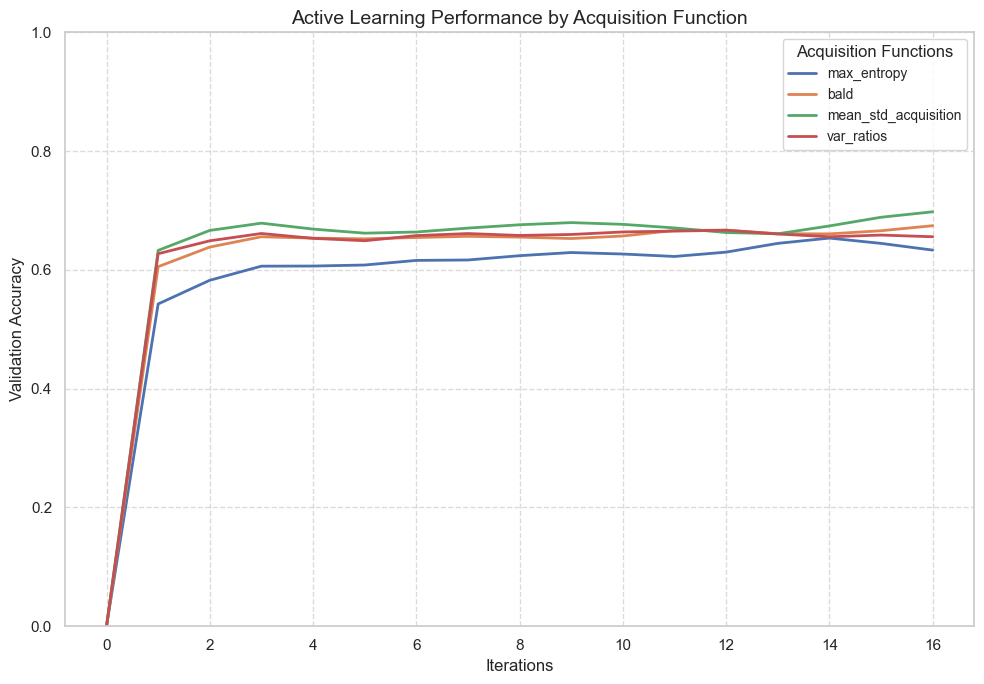

In [51]:
plot_results(data=results)